In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers 

###
import tensorflow.keras.utils as ku 
import numpy as np 

In [21]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

print(label.shape)

--2020-05-13 03:08:03--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-05-13 03:08:03 (136 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]

(15462, 3211)


In [29]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim =300, input_length=max_sequence_len))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation = 'relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))
model.add(Dense(total_words, activation = 'softmax'))
# Pick an optimizer
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'categorical_crossentropy')
print(model.summary())


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 11, 300)           963300    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 11, 256)           439296    
_________________________________________________________________
dropout_14 (Dropout)         (None, 11, 256)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 128)               164352    
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 3211)              208715    
Total params: 1,783,919
Trainable params: 1,783,919
Non-trainable params: 0
___________________________________________

In [30]:
 print(predictors.shape)
 history = model.fit(np.array(predictors), np.array(label), epochs=100, verbose=1)

(15462, 10)
Epoch 1/100
484/484 [==============================] - 8s 17ms/step - loss: 6.8400 - accuracy: 0.0239
Epoch 2/100
484/484 [==============================] - 8s 17ms/step - loss: 6.4711 - accuracy: 0.0250
Epoch 3/100
484/484 [==============================] - 8s 17ms/step - loss: 6.3274 - accuracy: 0.0329
Epoch 4/100
484/484 [==============================] - 9s 18ms/step - loss: 6.1990 - accuracy: 0.0382
Epoch 5/100
484/484 [==============================] - 9s 19ms/step - loss: 6.0758 - accuracy: 0.0399
Epoch 6/100
484/484 [==============================] - 8s 17ms/step - loss: 5.9399 - accuracy: 0.0444
Epoch 7/100
484/484 [==============================] - 8s 17ms/step - loss: 5.8114 - accuracy: 0.0469
Epoch 8/100
484/484 [==============================] - 9s 18ms/step - loss: 5.6826 - accuracy: 0.0525
Epoch 9/100
484/484 [==============================] - 8s 17ms/step - loss: 5.5661 - accuracy: 0.0581
Epoch 10/100
484/484 [==============================] - 8s 17ms/step -

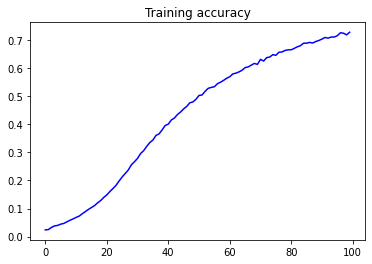

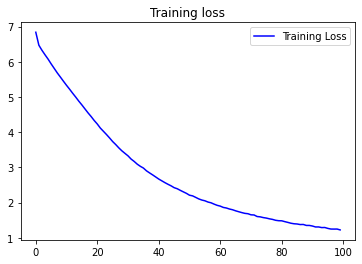

In [31]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [32]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Help me Obi Wan Kenobi, you're my only hope not be she care move erred decay will be forgot more red ' so strong fell tune delighted grave held taken untrue deeds of sun one store brought tell good bright light expire kind had stay afloat bad pace place not gives my sight doth cross one one days still may be hate more strong great verse more might torn seen hate live young days ' decrease light give bright light sit store hate told say good store i one bower rare express'd gone young days ' decrease brought her face will stay decay write to write not i not
